In [2]:
%matplotlib inline
import math
import os
import pylab
import scipy.optimize
from sympy import init_printing
from slimplectic_GGL import *
plot_path = './plots/'
init_printing()

In [3]:
#set up known variables and increment --------#
m = 1.0
k = 1.0
ll = 0.0001

dt = 0.1
tmax = 10000
t = [i*dt for i in  range(int( tmax/dt ) + 1 )]

In [4]:
q = Symbol('q')
v = Symbol('v')
tsym = Symbol('t')

qlist = [q]
vlist = [v]
qplist, qmlist = q_Generate_pm(qlist)
vplist, vmlist = q_Generate_pm(vlist)
[qp] = qplist
[qm] = qmlist
[vp] = vplist
[vm] = vmlist

L = 0.5*m*v**2 - 0.5*k*q**2
K = -ll*vp*qm

In [5]:
L,K

In [6]:
qi_sol_func2, q_np1_func2, pi_np1_func2, qdot_n_func2 = \
Gen_GGL_NC_VI_Map(tsym,
                   qlist, qplist, qmlist,
                   vlist, vplist, vmlist,
                   L,
                   K,
                   0, method='explicit')
qi_sol_func4, q_np1_func4, pi_np1_func4, qdot_n_func4 = \
Gen_GGL_NC_VI_Map(tsym,
                   qlist, qplist, qmlist,
                   vlist, vplist, vmlist,
                   L,
                   K,
                   1, method='explicit')

For Lagrangian:
	 L = - 0.5 q^{2} + 0.5 v^{2}
and K-potential:
	 K = - 0.0001 q_{-} v_{+}
********************
The Order 2 discretized Lagrangian is:
	 L_d^n = \frac{h_{{GGL}}}{2} \left(- \frac{{q^{{[n+1]}}}^{2}}{2} + \frac{\left({q^{{[n+1]}}} - {q^{{[n]}}}\right)^{2}}{2 h_{{GGL}}^{2}}\right) + \frac{h_{{GGL}}}{2} \left(- \frac{{q^{{[n]}}}^{2}}{2} + \frac{\left({q^{{[n+1]}}} - {q^{{[n]}}}\right)^{2}}{2 h_{{GGL}}^{2}}\right)
The Order 2 discretized K-potential is:
	 K_d^n = - \frac{{q^{{[n+1]}}}_{-}}{20000} \left({q^{{[n+1]}}}_{+} - {q^{{[n]}}}_{+}\right) - \frac{{q^{{[n]}}}_{-}}{20000} \left({q^{{[n+1]}}}_{+} - {q^{{[n]}}}_{+}\right)
********************
The Order 2 Discretized Equations of motion:
	0 = \pi^{{[n]}}_{q} - \frac{h_{{GGL}} {q^{{[n]}}}}{2} - \frac{{q^{{[n+1]}}}}{20000} + \frac{{q^{{[n]}}}}{20000} - \frac{{q^{{[n+1]}}}}{h_{{GGL}}} + \frac{{q^{{[n]}}}}{h_{{GGL}}}
	0 = - \pi^{{[n+1]}}_{q} - \frac{h_{{GGL}} {q^{{[n+1]}}}}{2} - \frac{{q^{{[n+1]}}}}{20000} + \frac{{q^{{[n]}}}}{2

In [7]:
def rk2(y , time , ddt , derivs) :
    #print y, time, ddt, derivs
    k1 = ddt*derivs(y , time)
    k2 = ddt*derivs(y + 0.5*k1 , time + 0.5*ddt)
    y_next = y + k2
    return y_next

def rk4(y , time , ddt , derivs) :
    k1 = ddt*derivs(y, time)
    k2 = ddt*derivs(y + 0.5*k1 , time + 0.5*ddt)
    k3 = ddt*derivs(y + 0.5*k2 , time + 0.5*ddt)
    k4 = ddt*derivs(y + k3, time + ddt)
    y_next = y + k1/6.0 + k2/3.0 + k3/3.0 + k4/6.0
    return y_next

In [8]:
def dydt(y, time):
    deriv = numpy.zeros(2)
    #print deriv
    [q_x, v_x] = y
    deriv[0] = v_x
    deriv[1] = - (k/m)*q_x - (ll/m)*v_x 
    #print(deriv)
    return deriv

def Energy(y, time):
    [q_x, v_x] = y
    E = 0.5*m*(v_x*v_x) + 0.5*k*(q_x*q_x)
    return E

def ASol(time):
    return exp(-ll*time/2.0)*cos(sqrt(k/m - ll*ll/4.0)*time)

def AEnergy(time):
    phi = - math.atan(2*sqrt(k/(m*ll*ll) - 4.0))
    return 0.5*k*k*exp(-ll*time)*(1 + ll/(2.0*sqrt(k/m))*cos( 2*sqrt(k/(m*ll*ll) - 4.0)*time + phi ))

In [9]:
qxrk2 = numpy.zeros(len(t))
vxrk2 = numpy.zeros(len(t))
Erk2 = numpy.zeros(len(t))

qxAS = numpy.zeros(len(t))

qxrk4 = numpy.zeros(len(t))
vxrk4 = numpy.zeros(len(t))
Erk4 = numpy.zeros(len(t))

q_GGL2 = numpy.zeros(len(t))
pi_GGL2 = numpy.zeros(len(t))
E_GGL2 = numpy.zeros(len(t))

q_GGL4 = numpy.zeros(len(t))
pi_GGL4 = numpy.zeros(len(t))
E_GGL4 = numpy.zeros(len(t))


In [10]:
qxrk2[0] = 1.0
qxrk4[0] = 1.0
qxAS[0] = 1.0
q_GGL2[0] = 1.0
q_GGL4[0] = 1.0

pi_GGL2[0] = 0.25*dt*k
#This initial condition is chosen because the 2nd order slimplectic method has p
#actually evaluated at the mid-step, and it needs corrections to that effect.
#otherwise the phase is off, and the energy has a constant offset. 

#qi_sol_func2, q_np1_func2, pi_np1_func2, qdot_n_func2
Erk2[0] = -1 + Energy([qxrk2[0],vxrk2[0]], t[0])/AEnergy(t[0])
Erk4[0] = -1 + Energy([qxrk4[0],vxrk4[0]], t[0])/AEnergy(t[0])
E_GGL2[0] = -1 + Energy([q_GGL2[0],pi_GGL2[0]/m], t[0])/AEnergy(t[0])
E_GGL4[0] = -1 + Energy([q_GGL4[0],pi_GGL4[0]/m], t[0])/AEnergy(t[0])


In [11]:
for i in range(1, len(t)-1):
    #Initialize rk2 old step
    yval=numpy.array([qxrk2[i-1], vxrk2[i-1]])
    #take step using rk2 algorithm
    yout = rk2(yval, t[i], dt, dydt)
    [qxrk2[i], vxrk2[i]] = yout
    Erk2[i] = -1 + Energy(yout, t[i])/AEnergy(t[i])
    
    #Initialize rk4 old step
    yval=numpy.array([qxrk4[i-1], vxrk4[i-1]])
    #take step using rk4 algorithm
    yout = rk4(yval, t[i], dt, dydt)
    [qxrk4[i], vxrk4[i]] = yout
    Erk4[i] = -1 + Energy(yout, t[i])/AEnergy(t[i])
    
    qi_sol2 = qi_sol_func2(numpy.array([q_GGL2[i-1]]), 
                          numpy.array([pi_GGL2[i-1]]), 
                          t[i-1], dt)
    [q_GGL2[i]] = q_np1_func2(qi_sol2, numpy.array([q_GGL2[i-1]]), 
                             numpy.array([pi_GGL2[i-1]]), 
                             t[i-1], dt)
    [pi_GGL2[i]] = pi_np1_func2(qi_sol2, numpy.array([q_GGL2[i-1]]), 
                               numpy.array([pi_GGL2[i-1]]), 
                               t[i-1], dt)    
    E_GGL2[i] = -1 + Energy([q_GGL2[i],pi_GGL2[i]/(m + 0.5*ll*dt)], t[i])/AEnergy(t[i])
    
    qi_sol4 = qi_sol_func4(numpy.array([q_GGL4[i-1]]), 
                          numpy.array([pi_GGL4[i-1]]), 
                          t[i-1], dt)
    [q_GGL4[i]] = q_np1_func4(qi_sol4, numpy.array([q_GGL4[i-1]]), 
                             numpy.array([pi_GGL4[i-1]]), 
                             t[i-1], dt)
    [pi_GGL4[i]] = pi_np1_func4(qi_sol4, numpy.array([q_GGL4[i-1]]), 
                               numpy.array([pi_GGL4[i-1]]), 
                               t[i-1], dt)    
    E_GGL4[i] = -1 + Energy([q_GGL4[i],pi_GGL4[i]/(m + 0.5*ll*dt)], t[i])/AEnergy(t[i])

    
    #Analytic Solution
    qxAS[i] = ASol(t[i])
    

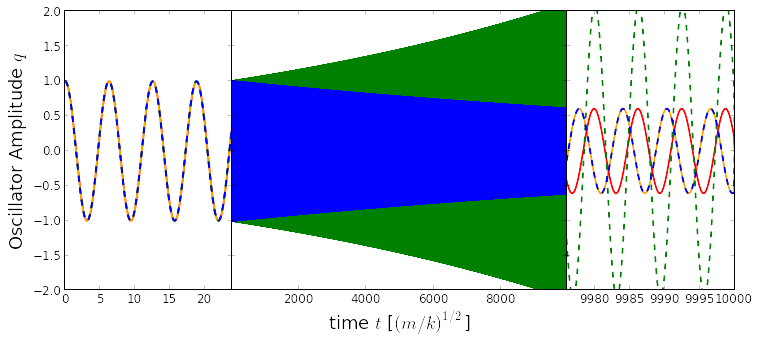

In [29]:
fig1 = pylab.figure(figsize=(12,5), dpi=800)
fig1.subplots_adjust(wspace=0)
ax1a = fig1.add_subplot(1,4,1)
ax1a.set_ylim(-2, 2)
ax1a.set_xlim(0,24)
#ax1.plot(t,qxrk2,linewidth=2.0, linestyle='-', color='g')
#ax1.plot(t[20000:21000],qxrk4[20000:21000],linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t,qxrk4,linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t[20000:21000],q_GGL2[:,0][20000:21000],linewidth=2.0, linestyle=':', color='r')
#ax1.plot(t[20000:21000],q_GGL6[:,0][20000:21000],linewidth=2.0, linestyle=':', color='orange')
ax1a.plot(t,q_GGL2,linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1a.plot(t,q_GGL4,linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1a.plot(t,qxrk2,linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1a.plot(t,qxrk4,linewidth=2.0, linestyle='--', color='blue', rasterized=True)
#ax1.plot(t,q_GGL4[:,0]-q_GGL6[:,0],linewidth=2.0, linestyle=':', color='red')


ax1b = fig1.add_subplot(1,4,(2,3))
pylab.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-2, 2)
ax1b.set_xlim(24.9,9975.9)
#ax1.plot(t,qxrk2,linewidth=2.0, linestyle='-', color='g')
#ax1.plot(t[20000:21000],qxrk4[20000:21000],linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t,qxrk4,linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t[20000:21000],q_GGL2[:,0][20000:21000],linewidth=2.0, linestyle=':', color='r')
#ax1.plot(t[20000:21000],q_GGL6[:,0][20000:21000],linewidth=2.0, linestyle=':', color='orange')
ax1b.plot(t,q_GGL2,linewidth=2.0, linestyle='-', color='red',rasterized=True)
ax1b.plot(t,q_GGL4,linewidth=2.0, linestyle='-', color='orange',rasterized=True)
ax1b.plot(t,qxrk2,linewidth=2.0, linestyle='-', color='g',rasterized=True)
ax1b.plot(t,qxrk4,linewidth=2.0, linestyle='-', color='blue',rasterized=True)
#ax1.plot(t,q_GGL4[:,0]-q_GGL6[:,0],linewidth=2.0, linestyle=':', color='red')

ax1c = fig1.add_subplot(1,4,4)
pylab.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-2, 2)
ax1c.set_xlim(9976,10000)
#ax1.plot(t,qxrk2,linewidth=2.0, linestyle='-', color='g')
#ax1.plot(t[20000:21000],qxrk4[20000:21000],linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t,qxrk4,linewidth=2.0, linestyle='-', color='b')
#ax1.plot(t[20000:21000],q_GGL2[:,0][20000:21000],linewidth=2.0, linestyle=':', color='r')
#ax1.plot(t[20000:21000],q_GGL6[:,0][20000:21000],linewidth=2.0, linestyle=':', color='orange')
ax1c.plot(t,q_GGL4,linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1c.plot(t,q_GGL2,linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1c.plot(t,qxrk2,linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1c.plot(t,qxrk4,linewidth=2.0, linestyle='--', color='blue', rasterized=True)
#ax1.plot(t,q_GGL4[:,0]-q_GGL6[:,0],linewidth=2.0, linestyle=':', color='red')

ax1a.tick_params(axis='both', which='major', labelsize=12)
ax1b.tick_params(axis='both', which='major', labelsize=12)
ax1c.tick_params(axis='both', which='major', labelsize=12)


ax1b.set_xlabel('time $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax1a.set_ylabel('Oscillator Amplitude $q$', fontsize=18)

In [30]:
fig1.savefig(plot_path + "DampSimpleCombined.pdf", transparent=True,bbox_inches='tight', dpi=500)

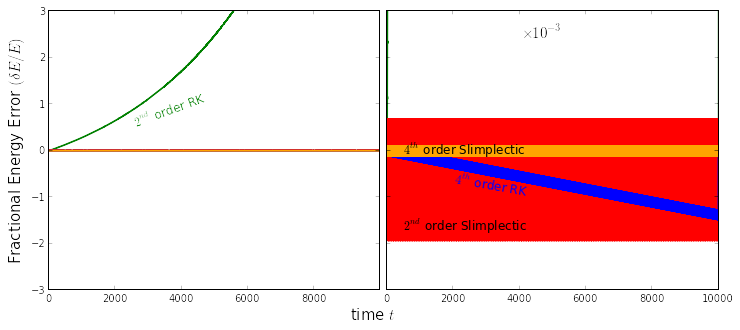

In [14]:

fig3 = pylab.figure(figsize=(12,5), dpi=800)
fig3.subplots_adjust(wspace=0.02)
ax3 = fig3.add_subplot(1,2,1)
ax3.set_ylim(-3.0,3.0)
ax3.set_xlim(0,9999)
#ax3.plot(t,1.0-(Erk2/E_GGL4) ,linewidth=2.0, linestyle='-', color='g')
#ax3.plot(t,1.0-(E_GGL2/E_GGL4) ,linewidth=2.0, linestyle='-', color='b')
#ax3.plot(t,1.0-(Erk4/E_GGL4) ,linewidth=2.0, linestyle='-', color='r')
ax3.plot(t,(Erk2)*1e0 ,linewidth=2.0, linestyle='-', color='g')
ax3.plot(t,(E_GGL2)*1e0 ,linewidth=2.0, linestyle='-', color='r')
ax3.plot(t,(Erk4)*1e0 ,linewidth=2.0, linestyle='-', color='b')
ax3.plot(t,(E_GGL4)*1e0 ,linewidth=2.0, linestyle='-', color='orange')
#ax3.text(700, 0.4, r'$\times 10^{-2}$', fontsize=15)
ax3.text(2500, 1, r'$2^{nd}$ order RK', fontsize=12, color='g', rotation=20)


ax4 = fig3.add_subplot(1,2,2)
pylab.setp(ax4.get_yticklabels(), visible=False)
ax4.set_ylim(-3.0, 3.0)
ax4.set_xlim(0,10000)
#ax3.plot(t,1.0-(Erk2/E_GGL4) ,linewidth=2.0, linestyle='-', color='g')
#ax3.plot(t,1.0-(E_GGL2/E_GGL4) ,linewidth=2.0, linestyle='-', color='b')
#ax3.plot(t,1.0-(Erk4/E_GGL4) ,linewidth=2.0, linestyle='-', color='r')
ax4.plot(t,(Erk2)*1e3 ,linewidth=2.0, linestyle='-', color='g')
ax4.plot(t,(E_GGL2)*1e3 ,linewidth=2.0, linestyle='-', color='r')
ax4.plot(t,(Erk4)*1e3 ,linewidth=2.0, linestyle='-', color='b')
ax4.plot(t,(E_GGL4)*1e3 ,linewidth=2.0, linestyle='-', color='orange')
ax4.text(4000, 2.4, r'$\times 10^{-3}$', fontsize=15)
ax4.text(500, -1.75, r'$2^{nd}$ order Slimplectic', fontsize=12, color='black')
ax4.text(500, -0.12, r'$4^{th}$ order Slimplectic', fontsize=12, color='black')
ax4.text(2000, -0.75, r'$4^{th}$ order RK', fontsize=12, color='blue', rotation =-10)


#ax4.set_xlabel('time $t$', fontsize=18)
fig3.text(0.5, 0.04, 'time $t$', fontsize=15, ha='center')
ax3.set_ylabel('Fractional Energy Error $(\delta E/E)$', fontsize=15)

In [15]:
fig3.savefig(plot_path + "DampSimpleECombined.png", transparent=True,bbox_inches='tight', dpi=300)

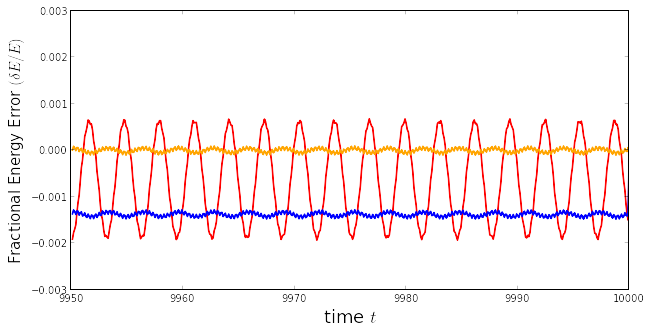

In [16]:
fig5 = pylab.figure(figsize=(10,5), dpi=500)
ax5 = fig5.add_subplot(1,1,1)
ax5.set_ylim(-0.003, 0.003)
#ax5.set_xlim(0, 5000)
ax5.plot(t[-500:],E_GGL2[-500:],linewidth=2.0, linestyle='-', color='r')
ax5.plot(t[-500:],E_GGL4[-500:],linewidth=2.0, linestyle='-', color='orange')
ax5.plot(t[-500:],Erk4[-500:],linewidth=2.0, linestyle='-', color='b')
ax5.plot(t[-500:],Erk2[-500:],linewidth=2.0, linestyle='-', color='g')
ax5.set_xlabel('time $t$', fontsize=18)
ax5.set_ylabel('Fractional Energy Error $(\delta E/E)$', fontsize=15)

In [17]:
#fig5.savefig(plot_path + "DampSimpleEZoomLast.png", transparent=True,bbox_inches='tight')

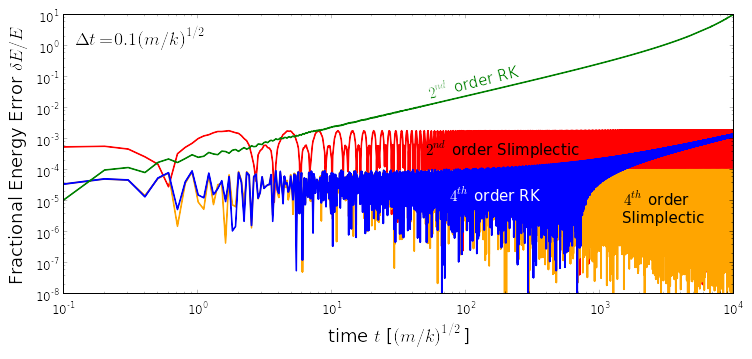

In [26]:
fig6 = pylab.figure(figsize=(12,5), dpi=500)
ax6a = fig6.add_subplot(1,1,1)
ax6a.set_ylim(1e-8, 1e1)
ax6a.set_xscale('log')
ax6a.set_yscale('log')
ax6a.set_xlim(0.1, 10000)
ax6a.plot(t,(abs(E_GGL2)+1e-20),linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax6a.plot(t,(abs(E_GGL4)+1e-20),linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax6a.plot(t,(abs(Erk4)+1e-20),linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax6a.plot(t,(abs(Erk2)+1e-20),linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax6a.set_xlabel('time $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax6a.set_ylabel('Fractional Energy Error $\delta E/E$', fontsize=18)
ax6a.text(0.12, 1, r'$\Delta t = 0.1 (m/k)^{1/2}$', fontsize=18, color='black')
ax6a.text(50, 3e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax6a.text(1500, 2e-6, r'$4^{th}$ order'+'\n'+'Slimplectic', fontsize=15, color='black')
ax6a.text(75, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='white')
ax6a.text(50, 1e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=14)
ax6a.tick_params(axis='both', which='major', labelsize=12)

In [31]:
fig6.savefig(plot_path + "DampSimpleELog.pdf", transparent=True,bbox_inches='tight', dpi=300)

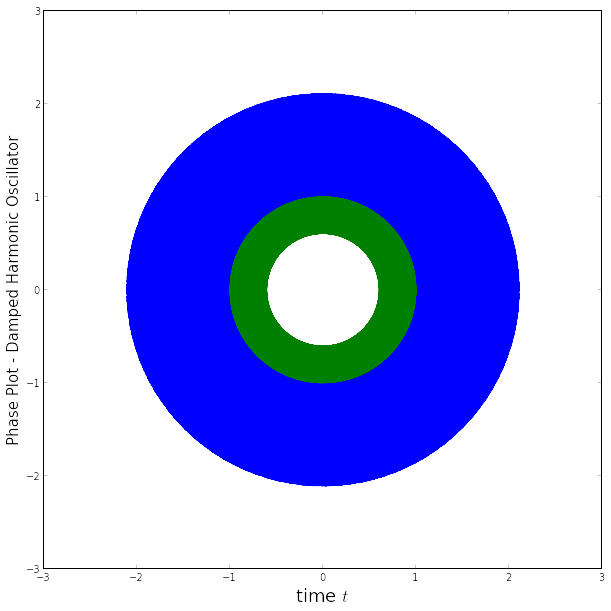

In [20]:
tmax = 10000;
imax = int(tmax/dt);

p_rk2=[]
p_rk4=[]
p_GGL2=[]
p_GGL4=[]

for i in range(len(t)):
    p_rk2.append(vxrk2[i]*m)
    p_rk4.append(vxrk4[i]*m)
    p_GGL2.append(pi_GGL2[i]*m)
    p_GGL4.append(pi_GGL4[i]*m)
    
fig7 = pylab.figure(figsize=(10,10), dpi=500)
ax7 = fig7.add_subplot(1,1,1)
ax7.set_ylim(-3, 3)
ax7.set_xlim(-3, 3)
ax7.scatter(q_GGL2[0],p_GGL2[0],color='black')
ax7.plot(q_GGL2[0:imax], p_GGL2[0:imax], linestyle='--', color='r')
ax7.plot(q_GGL4[0:imax], p_GGL4[0:imax], linestyle='--', color='orange')
ax7.plot(qxrk2[0:imax], p_rk2[0:imax], linestyle='--', color='b')
ax7.plot(qxrk4[0:imax], p_rk4[0:imax], linestyle='--', color='g')
ax7.set_xlabel('time $t$', fontsize=18)
ax7.set_ylabel('Phase Plot - Damped Harmonic Oscillator', fontsize=15)